Shape: (4362, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362 entries, 0 to 4361
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  1614 non-null   object 
 1   Price     4188 non-null   float64
 2   Rating    2312 non-null   float64
 3   Stock     3010 non-null   object 
 4   Discount  3970 non-null   float64
dtypes: float64(3), object(2)
memory usage: 170.5+ KB
None
  Category   Price    Rating         Stock  Discount
0      NaN  5548.0  1.870322           NaN       0.0
1      NaN  3045.0  4.757798           NaN      38.0
2      NaN  4004.0       NaN      In Stock       0.0
3      NaN  4808.0  1.492085           NaN      33.0
4      NaN  1817.0       NaN  Out of Stock      23.0
5      NaN  3522.0       NaN           NaN       NaN
6        C   667.0  3.668341      In Stock      41.0
7        A  7125.0  4.983998  Out of Stock       7.0
8        A  2777.0  2.678384      In Stock       6.0
9      NaN   46

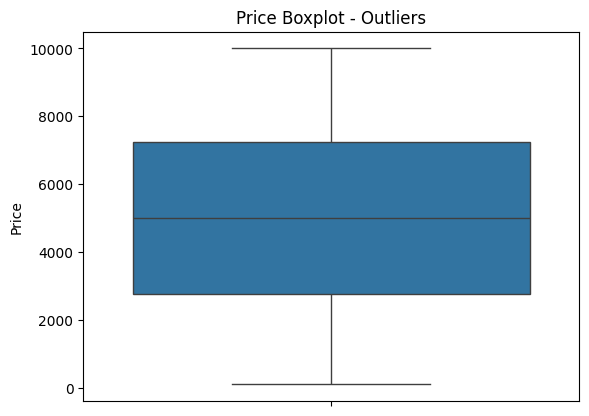

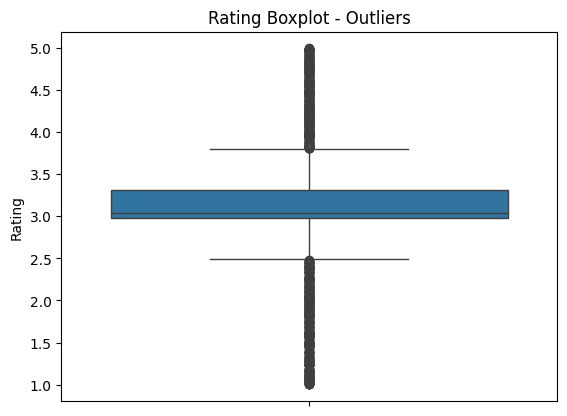

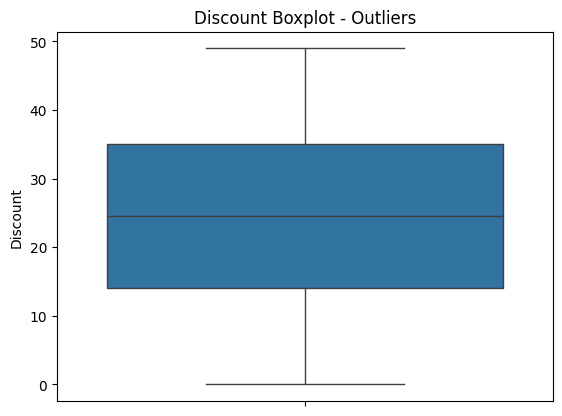

Corr Matrix:
              Price    Rating  Discount
Price     1.000000  0.036252 -0.005513
Rating    0.036252  1.000000 -0.003495
Discount -0.005513 -0.003495  1.000000


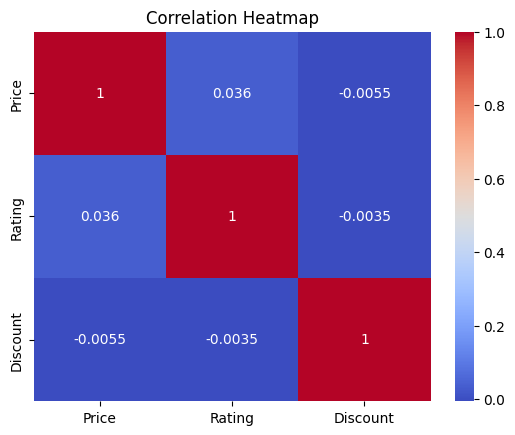

Selected Features: ['Discount']


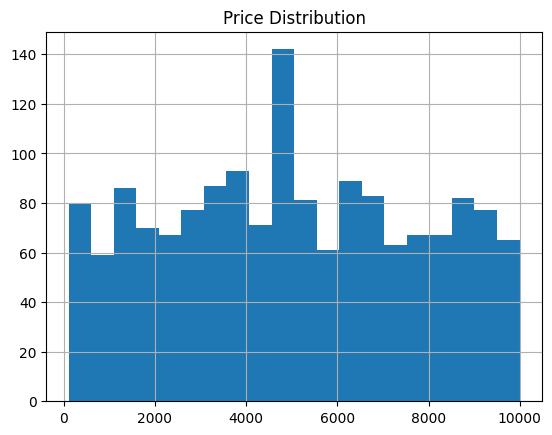

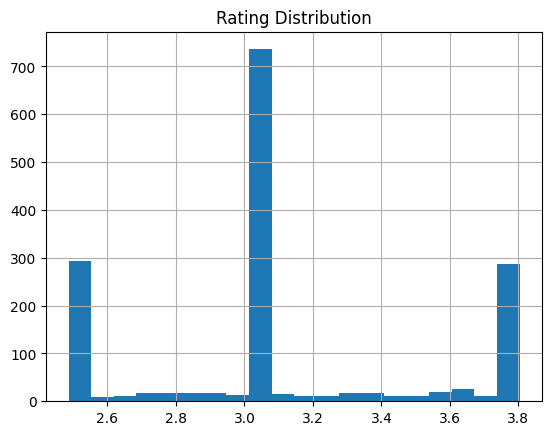

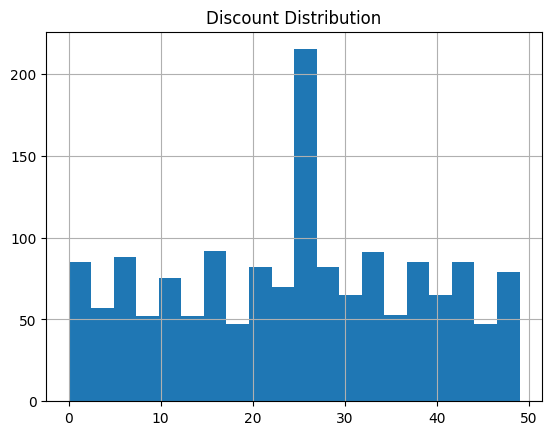

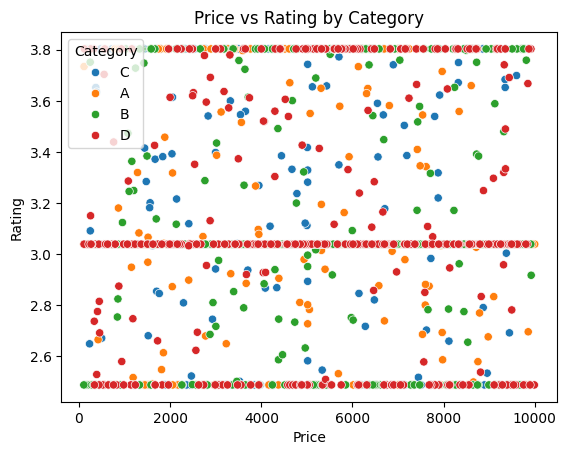

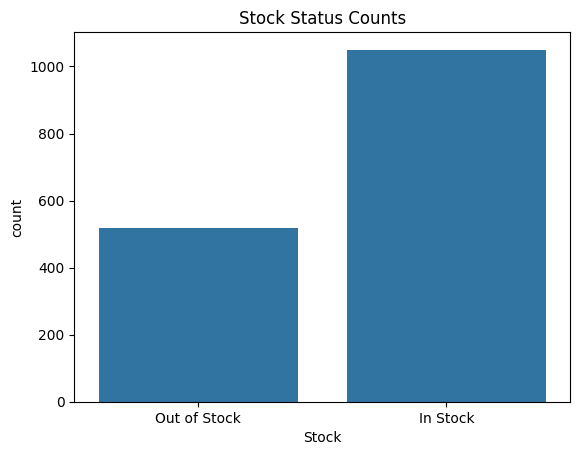

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
%matplotlib inline

df = pd.read_csv('synthetic_dataset.csv')

print("Shape:", df.shape)
print(df.info())
print(df.head(10))
print(df.describe())

print("Missing per Column:\n", df.isnull().sum())

df['Category'] = df['Category'].fillna(df['Category'].mode()[0])
df['Stock'] = df['Stock'].fillna(df['Stock'].mode()[0])
num_cols = ['Price', 'Rating', 'Discount']
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

print("After Impute Missing:", df.isnull().sum().sum())

print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()
print("After Drop Shape:", df.shape)

print("Category Unique:", df['Category'].unique())
print("Category Balance:\n", df['Category'].value_counts(normalize=True))

major_class = df['Category'].mode()[0]
major = df[df['Category'] == major_class]
min_size = df['Category'].value_counts().min()
major_down = resample(major, replace=False, n_samples=min_size)
minor_dfs = [df[df['Category'] == c] for c in df['Category'].unique() if c != major_class]
df_bal = pd.concat([major_down] + minor_dfs)

print("Balanced Shape:", df_bal.shape)
print("Balanced Counts:\n", df_bal['Category'].value_counts())

for col in num_cols:
    sns.boxplot(df_bal[col])
    plt.title(f'{col} Boxplot - Outliers')
    plt.show()

for col in num_cols:
    q1, q3 = df_bal[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    df_bal[col] = np.clip(df_bal[col], q1 - 1.5*iqr, q3 + 1.5*iqr)

corr = df_bal.corr(numeric_only=True)
print("Corr Matrix:\n", corr)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

if 'Discount' in df_bal.columns:
    corr_target = corr['Discount'].abs().sort_values(ascending=False)
    selected = corr_target[corr_target > 0.3].index
    print("Selected Features:", list(selected))

for col in num_cols:
    df_bal[col].hist(bins=20)
    plt.title(f'{col} Distribution')
    plt.show()

sns.scatterplot(x='Price', y='Rating', hue='Category', data=df_bal)
plt.title('Price vs Rating by Category')
plt.show()

sns.countplot(x='Stock', data=df_bal)
plt.title('Stock Status Counts')
plt.show()

df_bal = pd.get_dummies(df_bal, columns=['Category', 'Stock'], drop_first=True)

scaler = MinMaxScaler()
num_cols = df_bal.select_dtypes(include=np.number).columns
df_bal[num_cols] = scaler.fit_transform(df_bal[num_cols])